In [1]:
!nvidia-smi

Mon Dec  9 02:43:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install dependencies

In [3]:
!pip install -q ultralytics roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.2 MB/s eta 0:00:00


## Imports

In [4]:
from roboflow import Roboflow
from google.colab import userdata
from IPython.display import Image

## Pull dataset

In [5]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("cc-ysf62").project("best-football-detection")
version = project.version(2)
dataset = version.download("yolov8")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BEST-FOOTBALL-DETECTION--2 in yolov8:: 100%|██████████| 756/756 [00:00<00:00, 6540.97it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [7]:
!sed -i 's|\(train: \).*|\1../train/images|' {dataset.location}/data.yaml
!sed -i 's|\(val: \).*|\1../valid/images|' {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml


names:
- ball
- goalkeeper
- player
- referee
nc: 4
roboflow:
  license: CC BY 4.0
  project: best-football-detection
  url: https://universe.roboflow.com/cc-ysf62/best-football-detection/dataset/2
  version: 2
  workspace: cc-ysf62
test: ../test/images
train: ../train/images
val: ../valid/images


## Custom training

In [9]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8x.pt data={dataset.location}/data.yaml batch=5 epochs=50 imgsz=640 plots=True

/content
100% 131M/131M [00:00<00:00, 229MB/s]
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/datasets/BEST-FOOTBALL-DETECTION--2/data.yaml, epochs=50, time=None, patience=100, batch=5, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save

In [10]:
!ls {HOME}/runs/detect/train/

args.yaml					    R_curve.png		 val_batch0_labels.jpg
confusion_matrix_normalized.png			    results.csv		 val_batch0_pred.jpg
confusion_matrix.png				    results.png		 val_batch1_labels.jpg
events.out.tfevents.1733712482.a5d69194f3fc.1708.0  train_batch0.jpg	 val_batch1_pred.jpg
F1_curve.png					    train_batch1.jpg	 val_batch2_labels.jpg
labels_correlogram.jpg				    train_batch2400.jpg  val_batch2_pred.jpg
labels.jpg					    train_batch2401.jpg  weights
P_curve.png					    train_batch2402.jpg
PR_curve.png					    train_batch2.jpg


/content


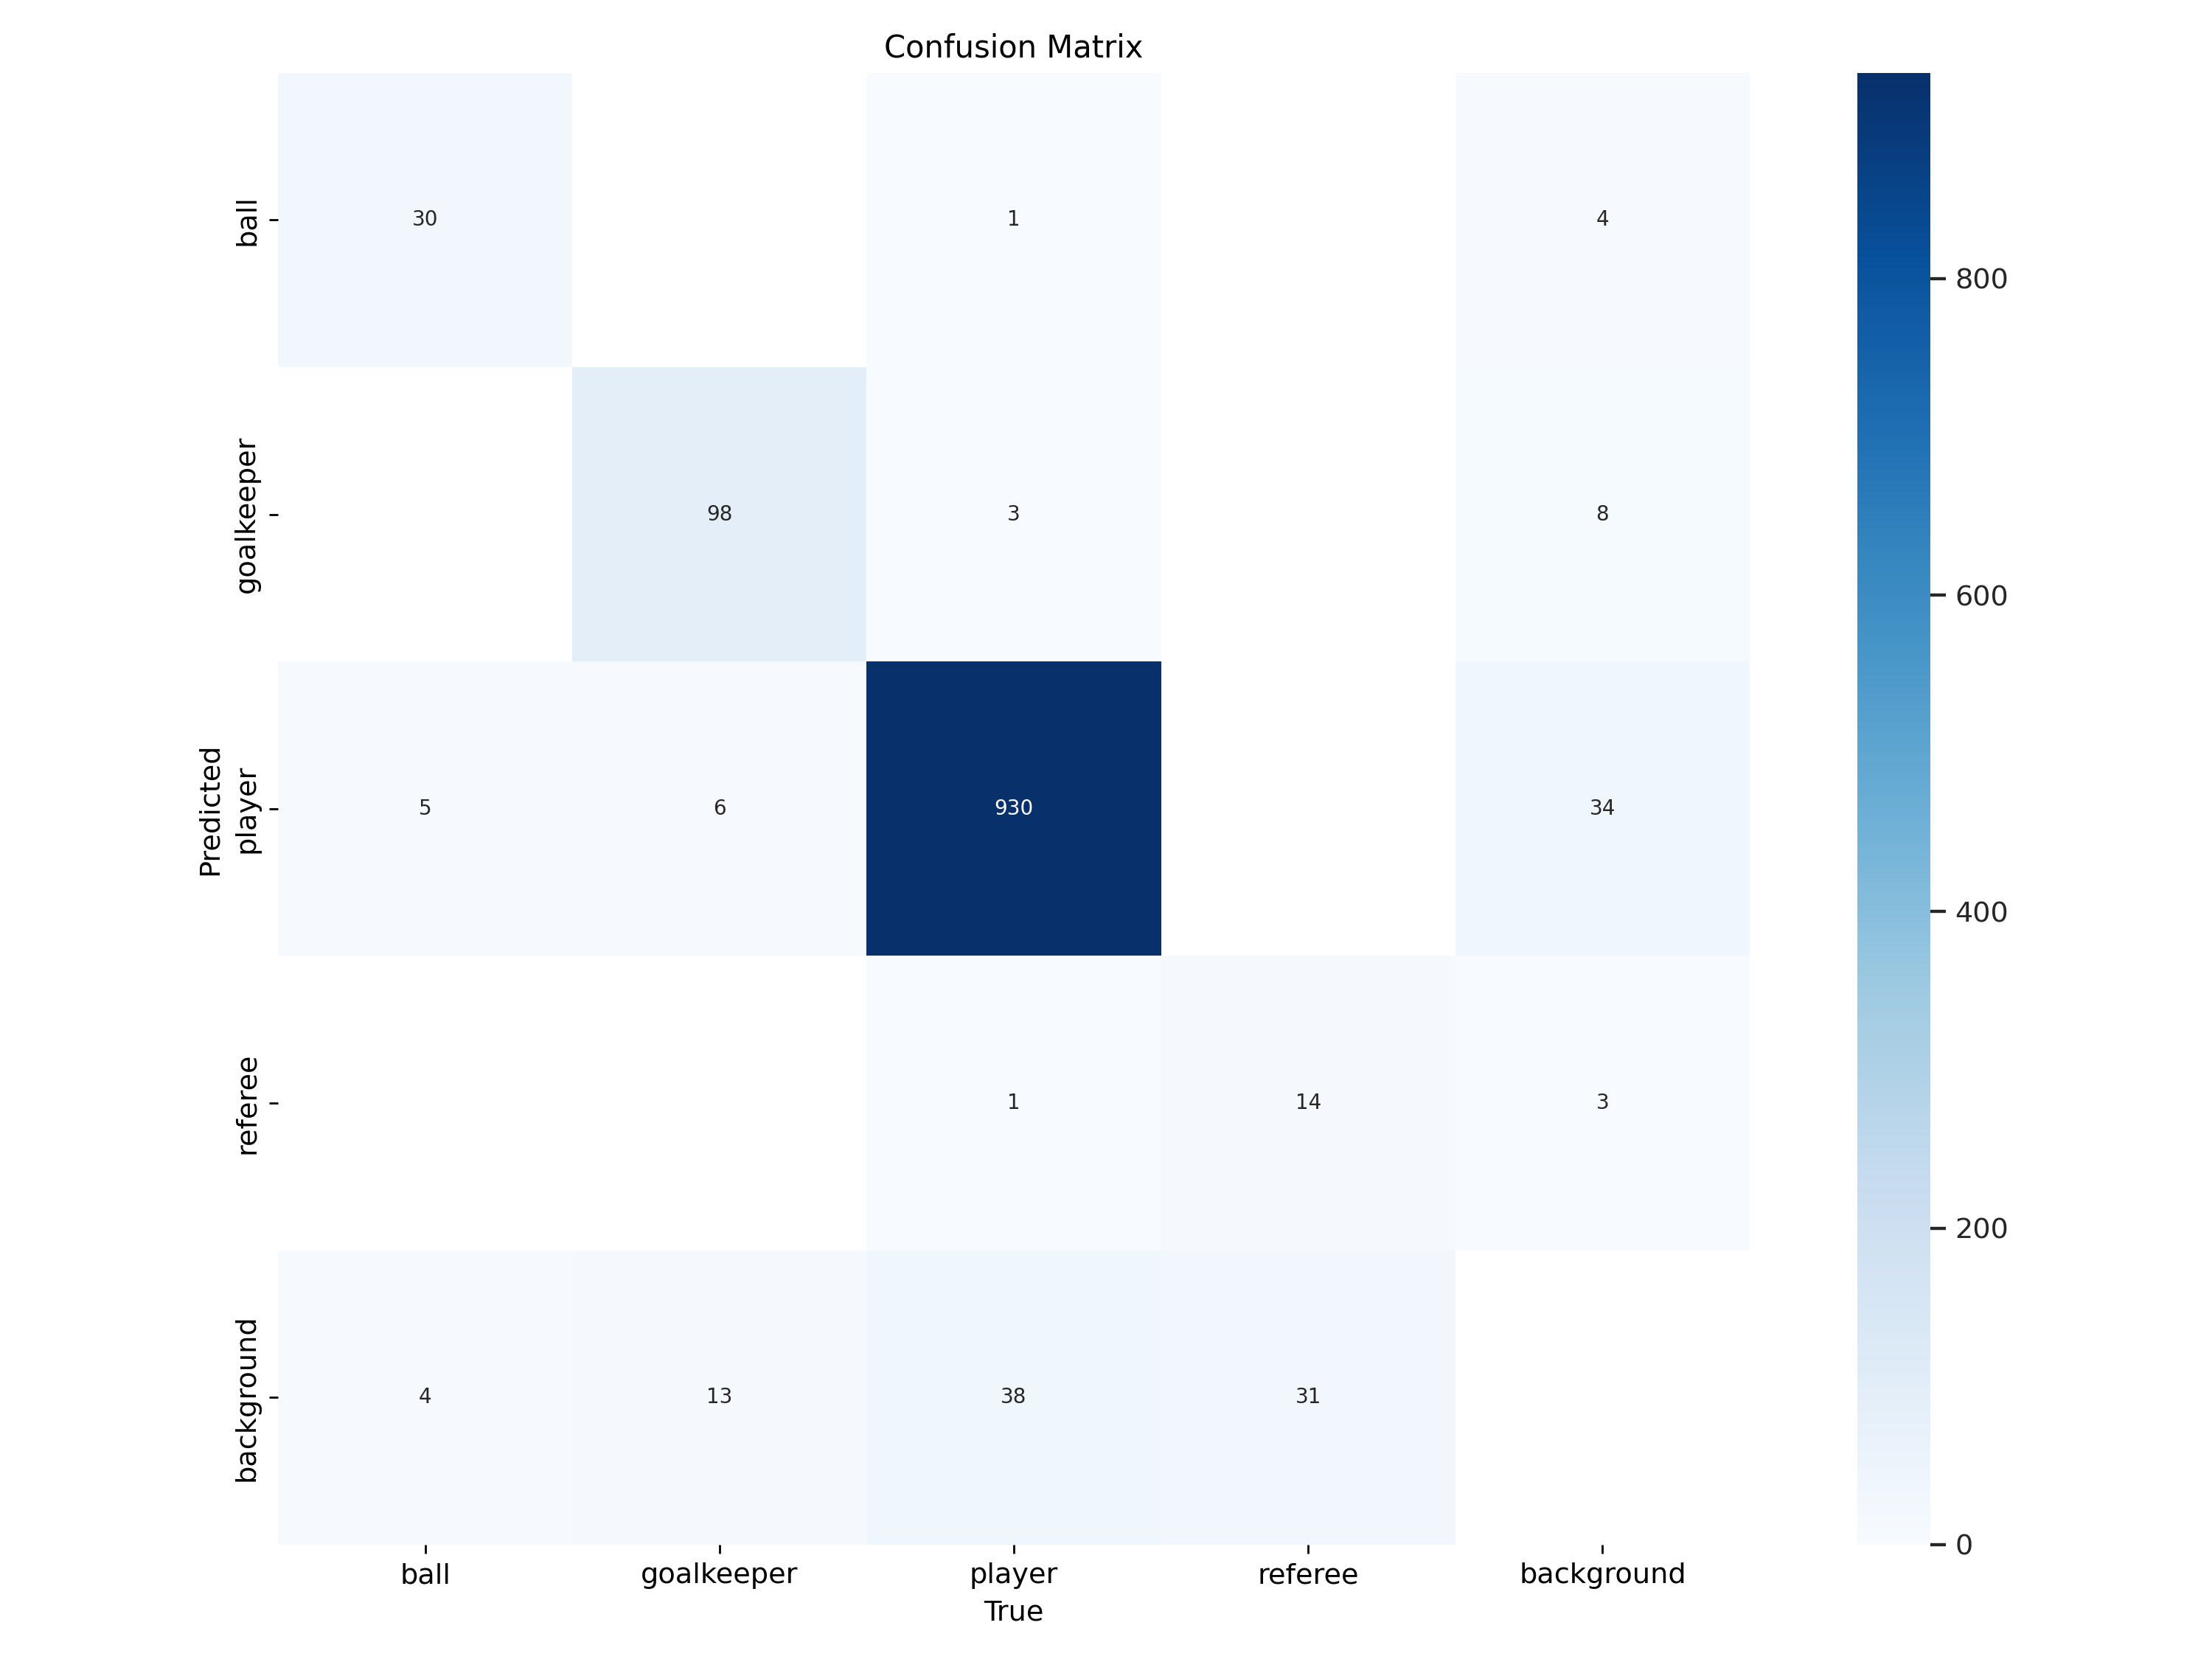

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


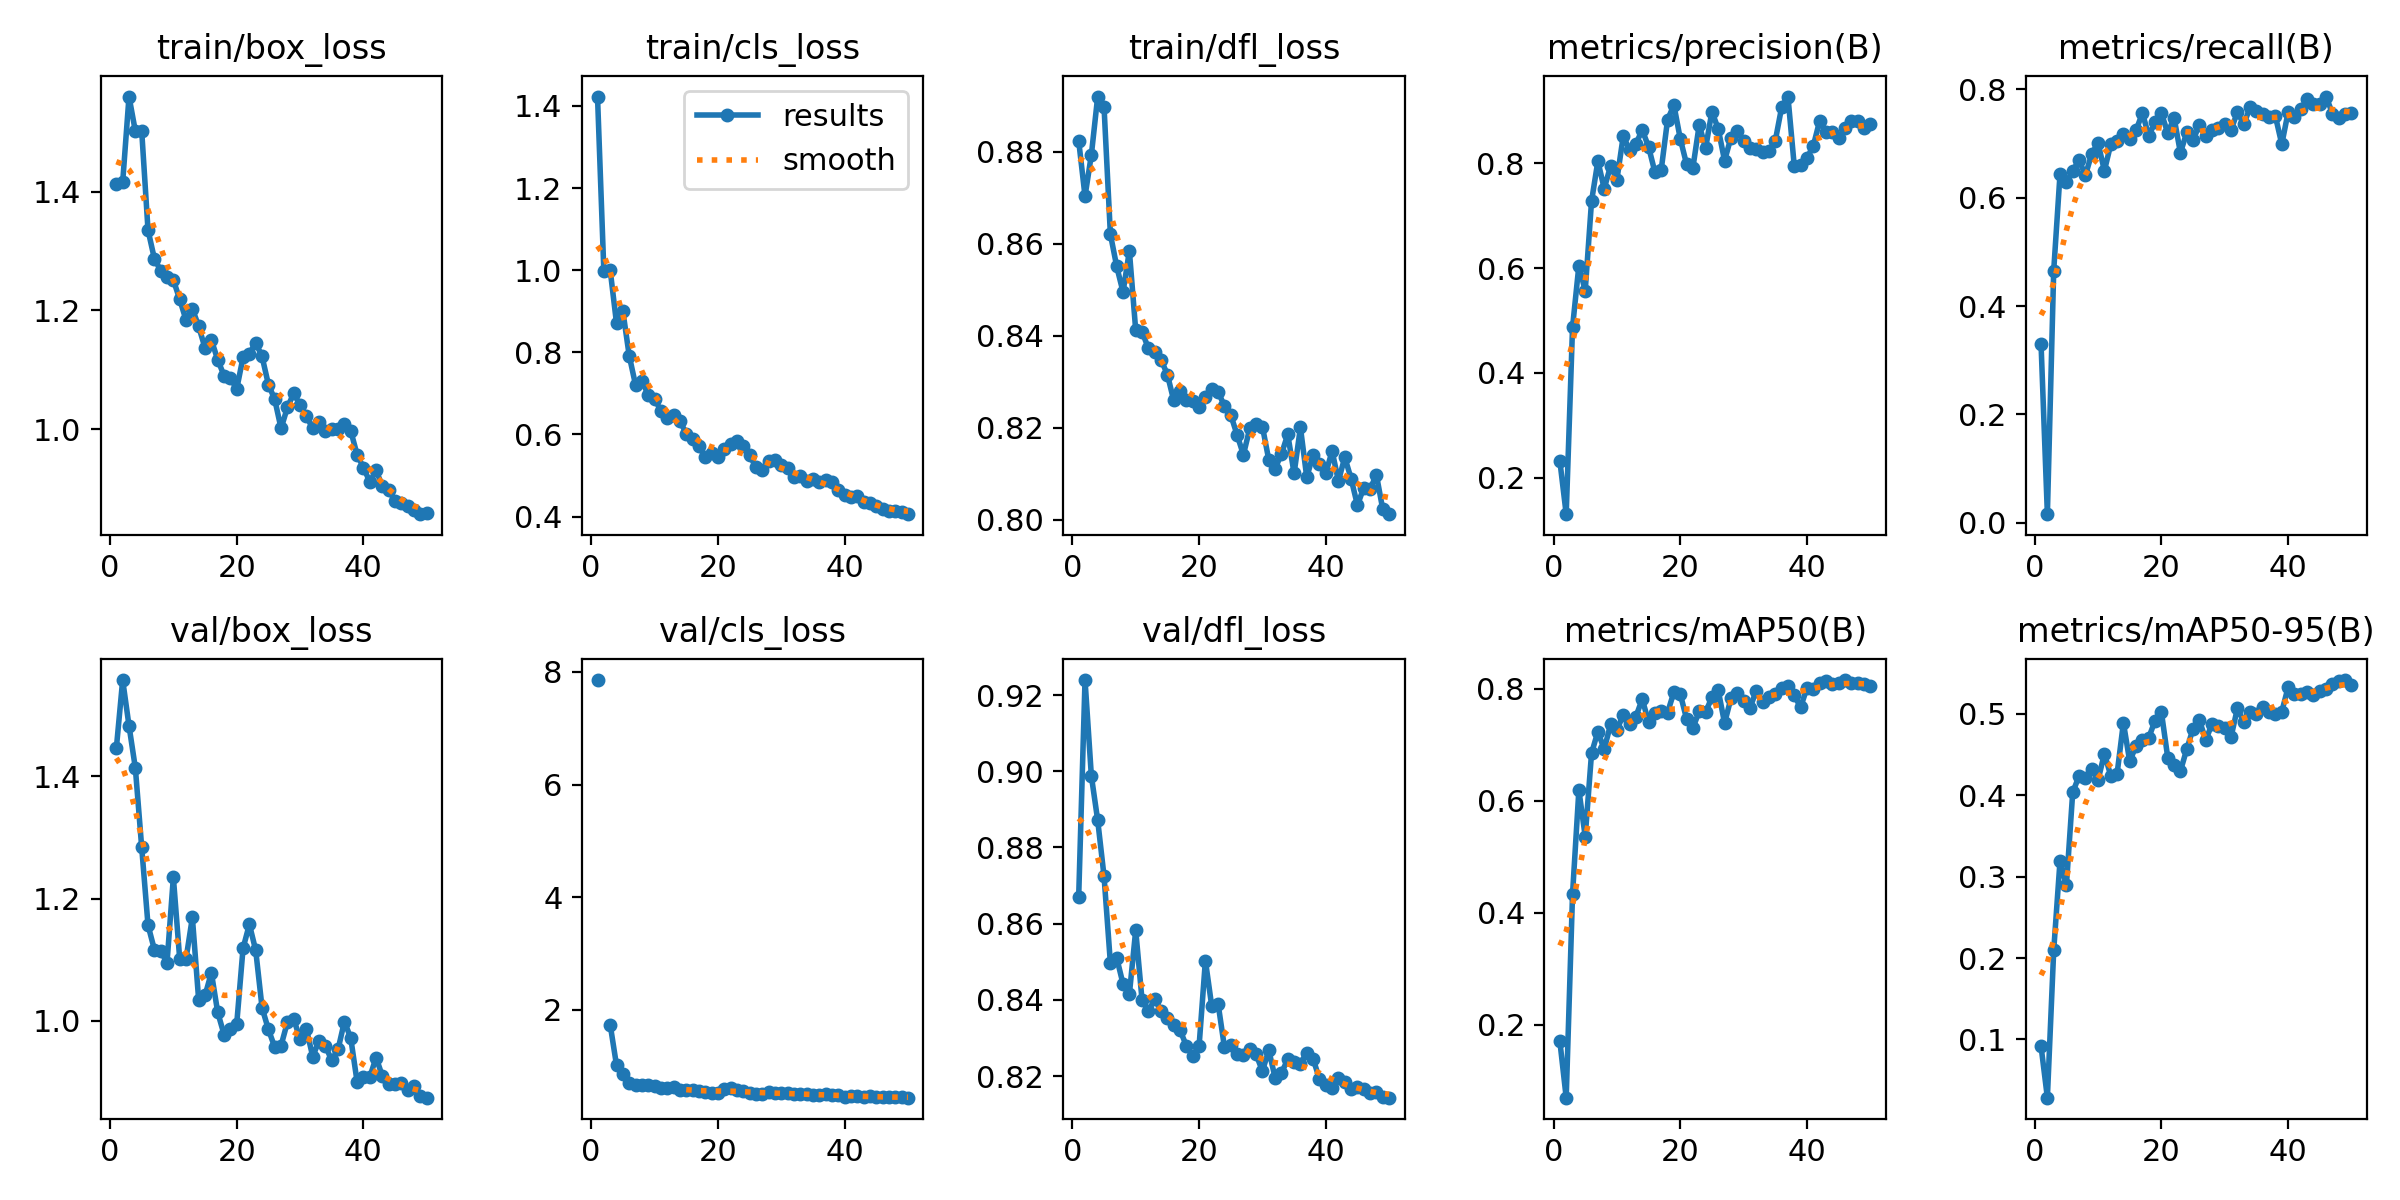

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


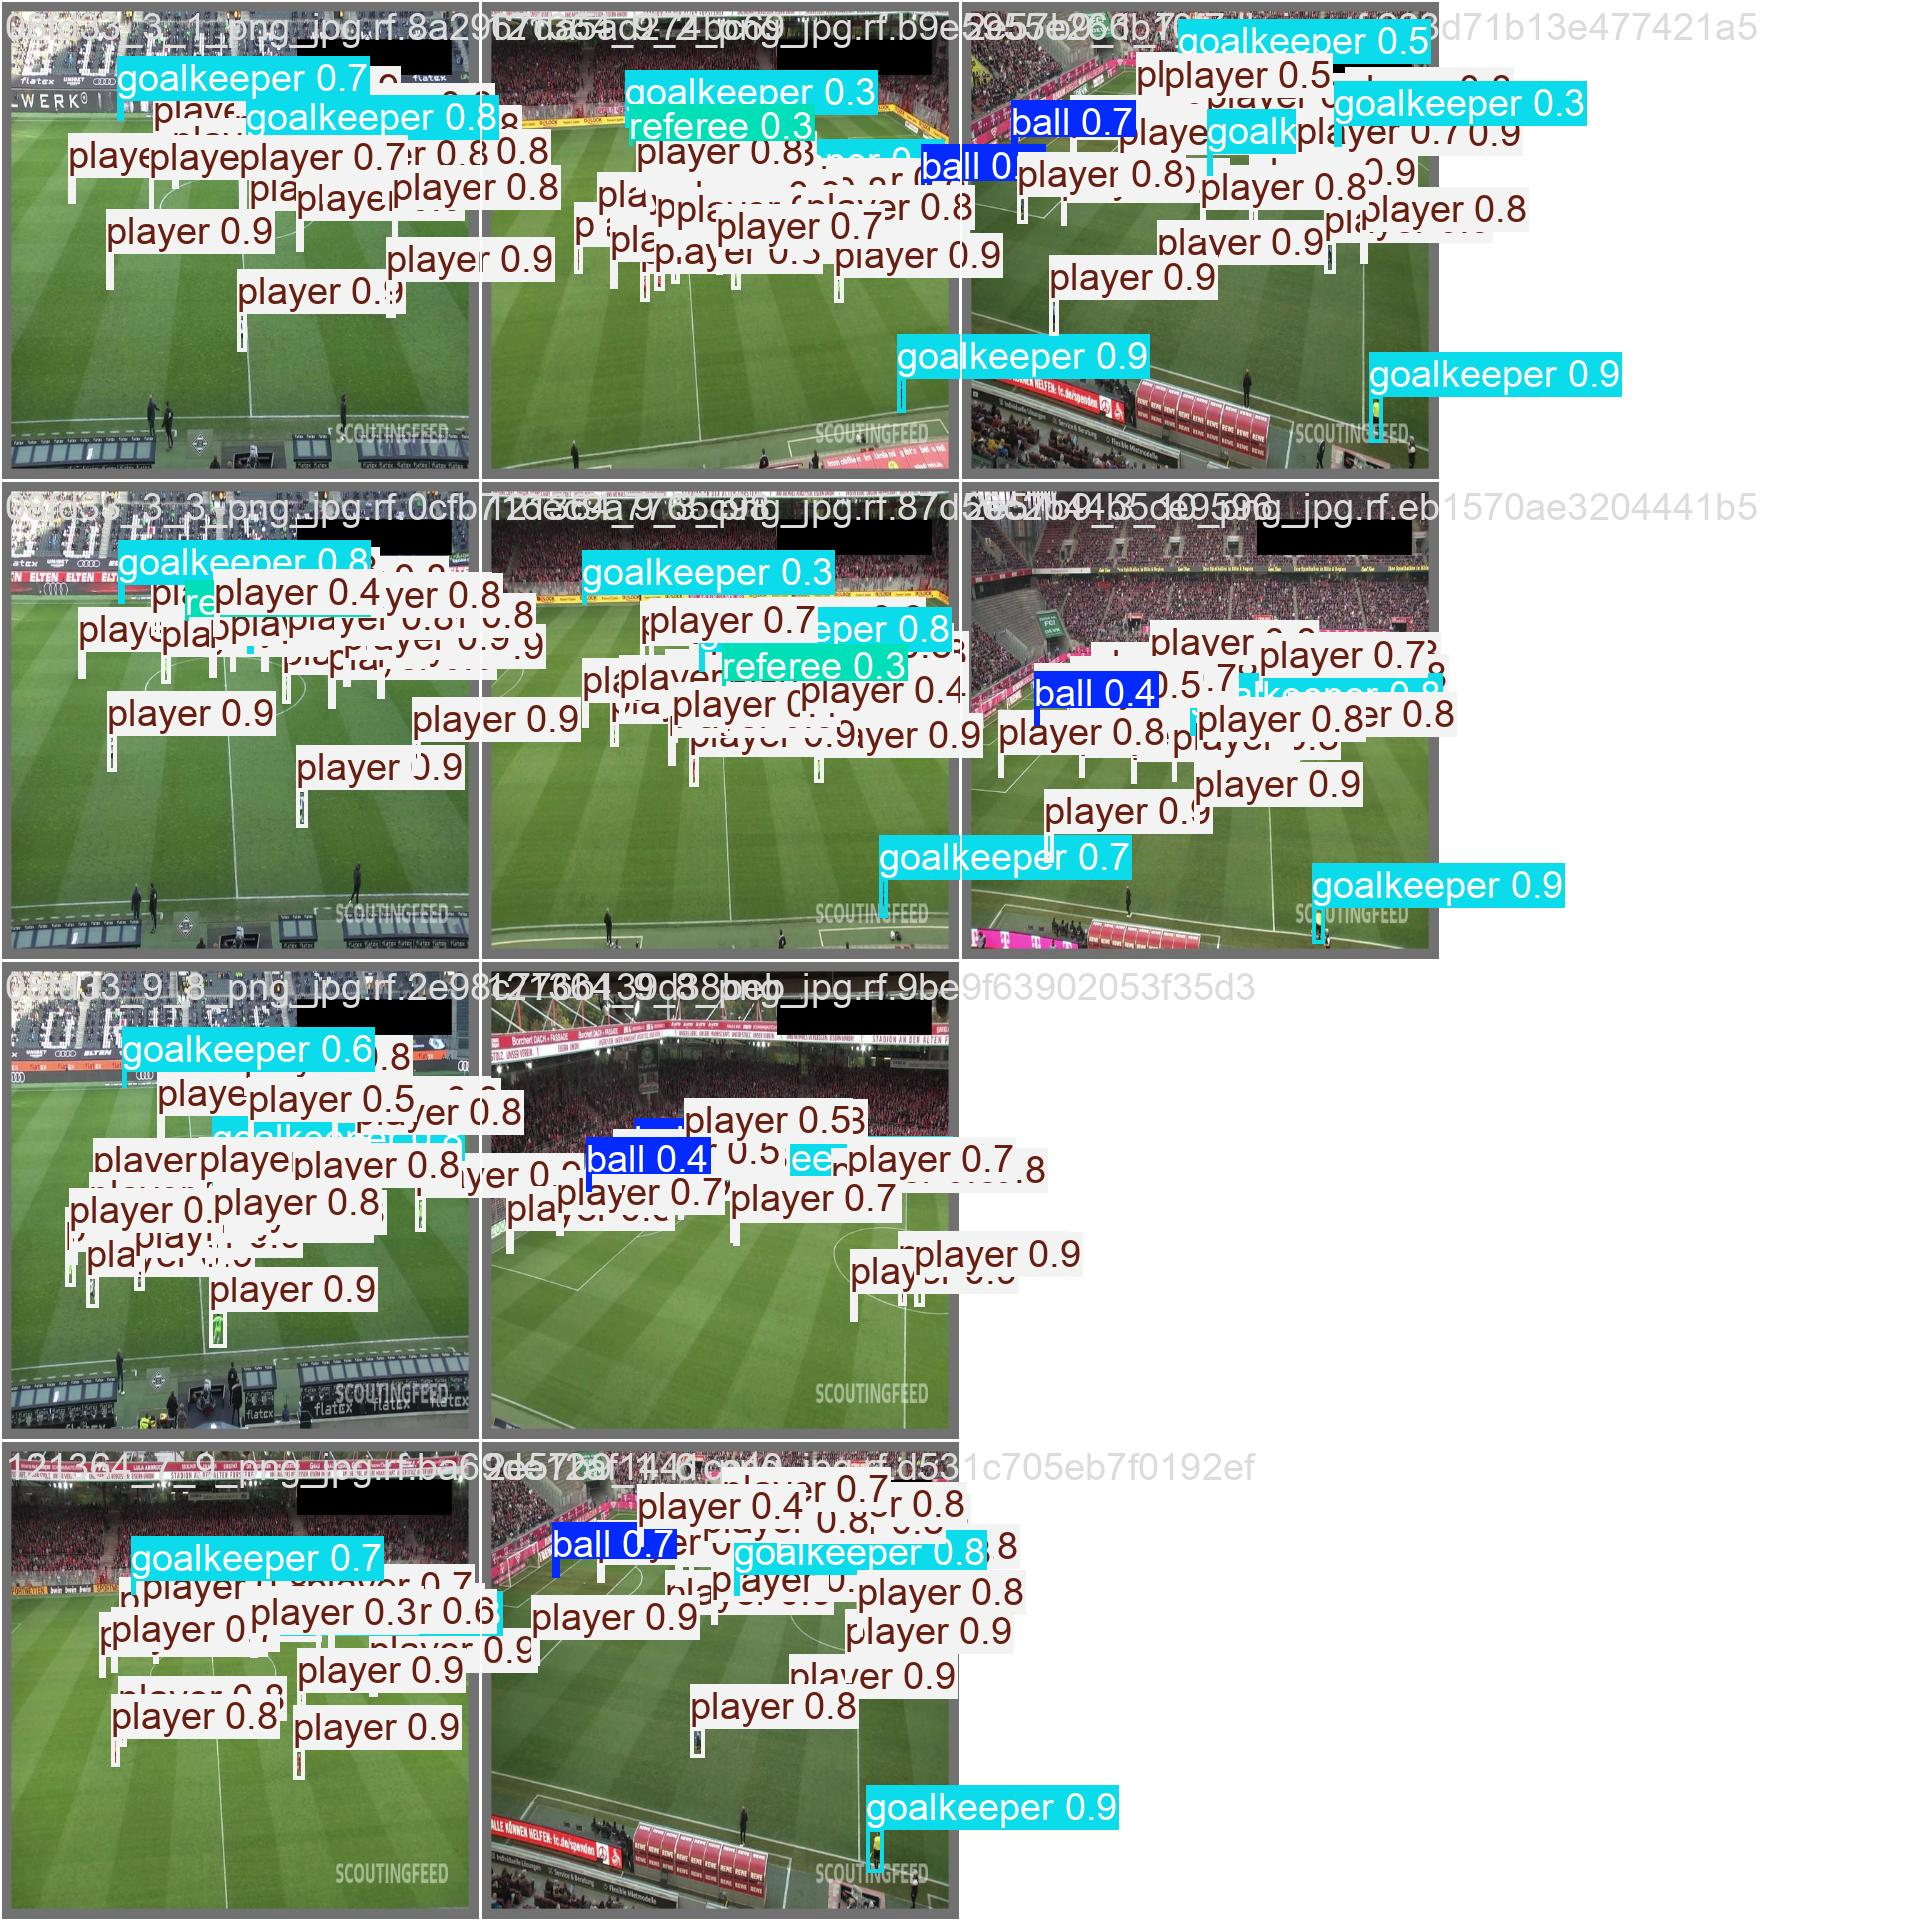

In [13]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Validate custom model

In [14]:
%cd {HOME}

!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml imgsz=1280

/content
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68,127,420 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning /content/datasets/BEST-FOOTBALL-DETECTION--2/valid/labels.cache... 49 images, 0 backgrounds, 0 corrupt: 100% 49/49 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 4/4 [00:13<00:00,  3.46s/it]
                   all         49       1174      0.915      0.751      0.818      0.492
                  ball         38         39      0.876      0.769      0.824      0.504
            goalkeeper         49        117      0.924      0.855      0.926      0.553
                player         49        973      0.959      0.966      0.985      0.723
               referee         45         45      0.903      0.413      0.535      0.189
Speed: 29.7ms preprocess, 216.1ms inference, 0.0ms loss, 14.6ms postprocess per image
Results saved to runs/de

## Deploy model on Roboflow

In [15]:
project.version(dataset.version).deploy(model_type="yolov8", model_path=f"{HOME}/runs/detect/train/")

Dependency ultralytics==8.0.196 is required but found version=8.3.48, to fix: `pip install ultralytics==8.0.196`
Would you like to continue with the wrong version of ultralytics? y/n: y
View the status of your deployment at: https://app.roboflow.com/cc-ysf62/best-football-detection/2
Share your model with the world at: https://universe.roboflow.com/cc-ysf62/best-football-detection/model/2
